# Abstract

# Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

N     = 2000

theta    = (np.random.uniform(size = N) * 2 - 1) * 1 + np.random.choice( [5, 10,15] ,size = N)
height   = np.random.uniform(size = N) * 1  + 2 # np.random.choice([1], size = N)
sigmasq  = 1 + 0 * np.random.choice([1,4,9], size = N)

t_space = np.linspace(0,1.1 * theta.max(), 100)
X       = jax.vmap(
    lambda th,h,ssq:
        jax.vmap(
            lambda t:
                jnp.exp( - (t - th)**2 / ssq ) * h
        )(t_space)
)(theta,height,sigmasq)

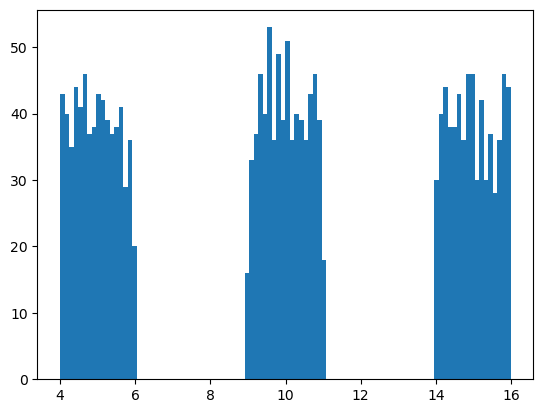

In [2]:
plt.hist(theta,bins = 100)
plt.show()

# Nadaraya Watson Optimal Embedding

In [3]:
def k(x,y):
    return jnp.exp ( - (1e2) * (x - y) @ (x - y) )
    
def predict(x,X,Y):
    # pesi del kernel
    K = jax.vmap(lambda x_i: k(x,x_i)   * ( (x - x_i) @  (x - x_i) > 0 )  )(X)
    print(K.shape)
    # costruzione basata sul kernel
    C = K[:,None] * Y
    # media pesata
    x_hat = C.sum(axis = 0) / K.sum()
    return x_hat

batch_predict = lambda X_in,X,Y : jax.vmap(lambda x: predict(x,X,Y))(X_in) 

E =  np.random.randn(len(X), 1)

@jax.jit
def loss(E,X):
    return ((  batch_predict(E,E,X) -  X )**2).sum()

grad = jax.grad(loss)

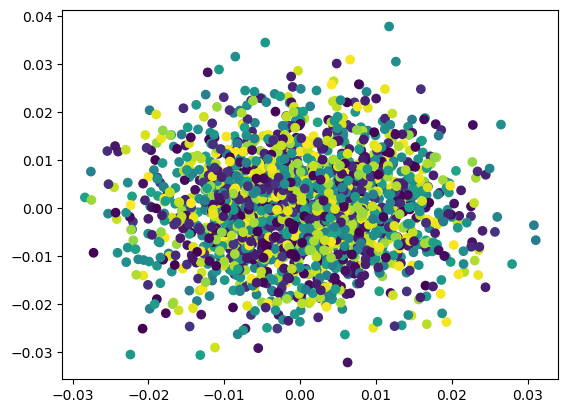

(2000,)
67081.26


  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]

(2000,)


13.629: 100%|██████████████████████████████████████████████████████████████████████| 3000/3000 [01:35<00:00, 31.54it/s]


In [4]:
from tqdm import tqdm

#E  = np.random.uniform(size = (len(X),2)) * 1e-2
E =  np.random.randn(len(X), 2) *  1e-2
plt.scatter(E[:,0] , E[:,1], c =  t_space[ X.argmax(axis =  1)])
plt.show()

print(loss(E,X))
bar = tqdm(range(3000))
lr  = 1e-4
for i in bar:
    new_E =  E - lr * grad(E,X)
    if loss(new_E,X) < loss(E,X):
        lr *= 1.1
        E   = new_E
    else:
        lr *= 0.8
    bar.set_description("%.3f" % loss(E,X))

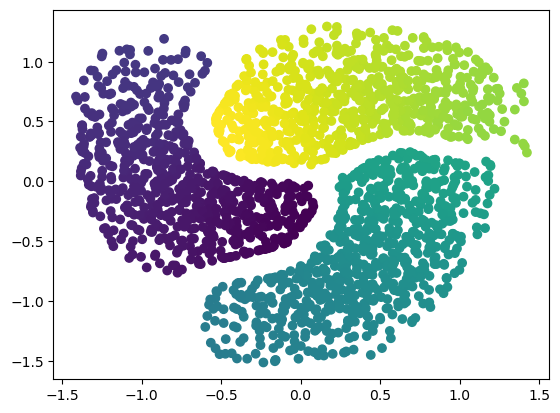

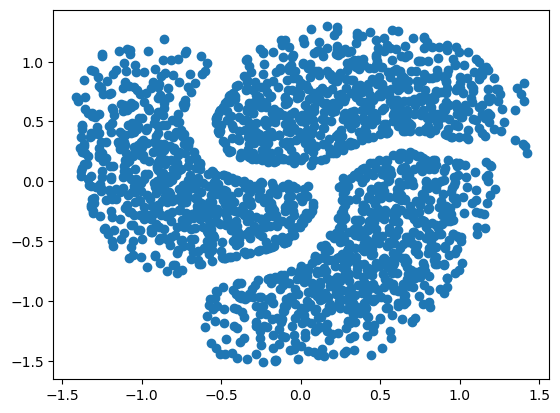

In [26]:
plt.scatter(E[:,0] , E[:,1], c = theta  )
plt.figure()
plt.scatter(E[:,0] , E[:,1])

In [16]:
theta

array([15.8308157 , 10.72763263, 10.71028267, ..., 15.84549855,
        4.58535543,  4.33358442])

In [6]:
jax

<module 'jax' from 'C:\\Users\\Luca\\anaconda3\\lib\\site-packages\\jax\\__init__.py'>

# Hierarchy Identification Algorithm

In [284]:
# inizializzo il labelling
L = np.ones(len(E)) * - 1
matched = np.zeros(len(E))
c = E.mean(axis = 0)



# trovo il piú vicino

for classe in range(3):
    for i in range(10):
        closest = np.arange(len(L))[L  == -1][np.linalg.norm(E[L == -1] - c,axis = 1).argmin()]
        L[closest] = classe
        print((L==classe).sum())
        for j,c in zip(np.arange(len(E))[np.logical_and(L == classe, matched == 0)], E[np.logical_and(L == classe, matched == 0)]):
            closest_altro = np.linalg.norm(E[L != classe] - c,axis = 1).argmin()
            L[ np.arange(len(L))[L != classe][closest_altro]] = classe
            matched[j] = 1
    plt.scatter(E[:,0],E[:,1], c = L)
    plt.show()

1
3
6
10


KeyboardInterrupt: 

# DBSCAN

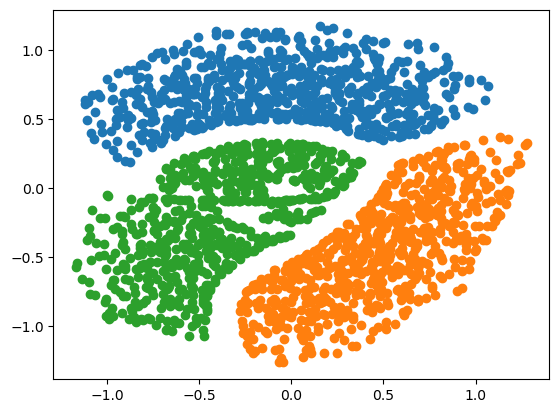

In [307]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import numpy as np

# Create KMeans model
kmeans = SpectralClustering(n_clusters=3,
        assign_labels='discretize',
        random_state=5,
        eigen_solver= 'arpack',
        gamma = 100.)

# Fit the model
kmeans.fit(E)

# Predict cluster labels
labels = kmeans.labels_

for c in np.unique(labels):
    plt.scatter(E[:,0][labels == c] , E[:,1][labels == c])

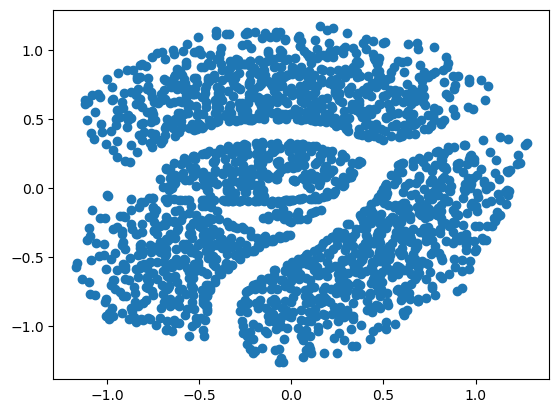

In [308]:
plt.scatter(E[:,0] , E[:,1])

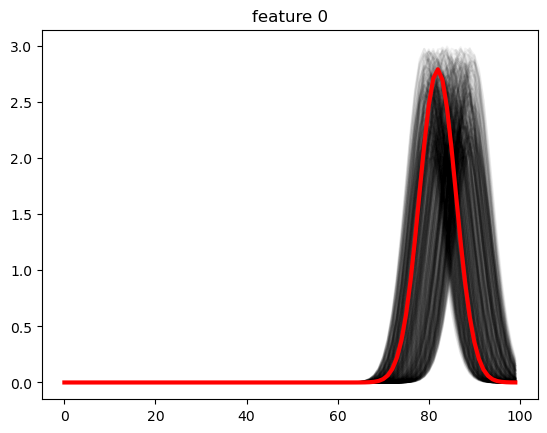

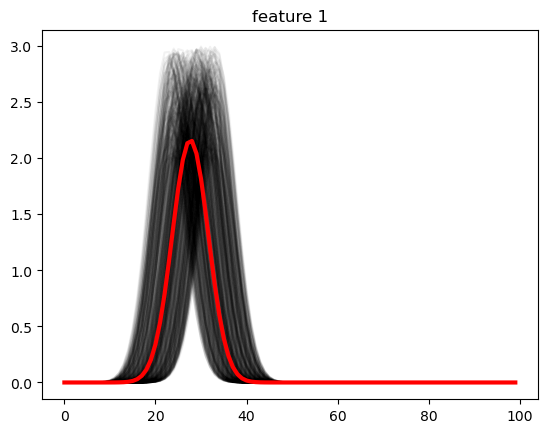

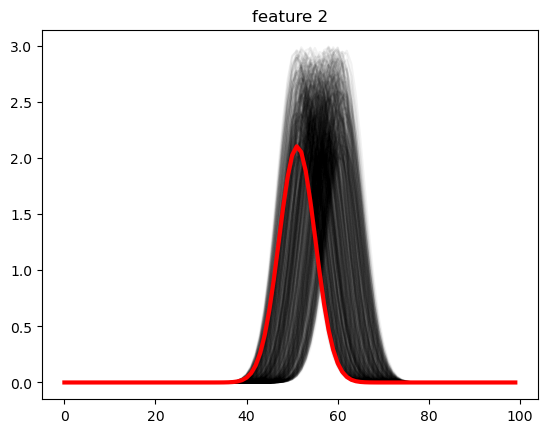

In [309]:
for i in np.unique(labels):
    plt.title("feature %d" % i)
    plt.plot( X[labels == i].T, color = 'black', alpha = 0.05)
    plt.plot( X[labels == i][np.random.choice((labels == i).sum())] , color = 'red', alpha = 1., lw = 3.)
    plt.show()

# PCA inside clusters

(2000,)
(2000,)
(2000,)


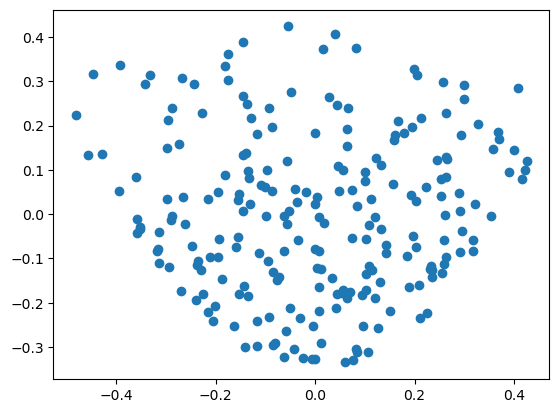

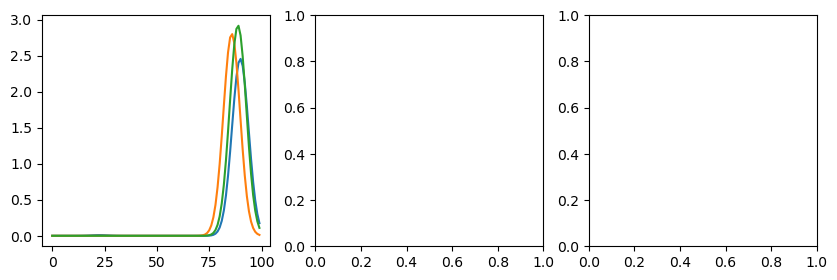

In [351]:
E_1 = E[labels == 0]
query = E_1[np.random.choice(len(E_1))]
E_1 = E_1[ np.linalg.norm(E_1 - query,  axis = 1) < 0.7 ]
mu  =  E_1.mean(axis = 0)
E_1_zc = E_1 - mu
U,s,Vt = np.linalg.svd(E_1_zc, full_matrices = False)
E_whitened = E_1_zc @ Vt.T

plt.scatter(E_whitened[:,0], E_whitened[:,1])

p_1 = E_whitened[np.linalg.norm(E_whitened).argmin()] @ Vt + mu
p_2 = E_whitened[np.linalg.norm(E_whitened -  2 * np.array([1.,0.] ), axis = 1).argmin()]  @ Vt + mu
p_3 = E_whitened[np.linalg.norm(E_whitened -  2 * np.array([0.,1.] ), axis = 1).argmin()]  @ Vt + mu



axs = plt.figure(figsize=(10,3)).subplots(nrows = 1, ncols = 3).flatten()
axs[0].plot( predict(p_1,E,X))
axs[0].plot( predict(p_2,E,X))
axs[0].plot( predict(p_3,E,X))


# Langevin Dynamics

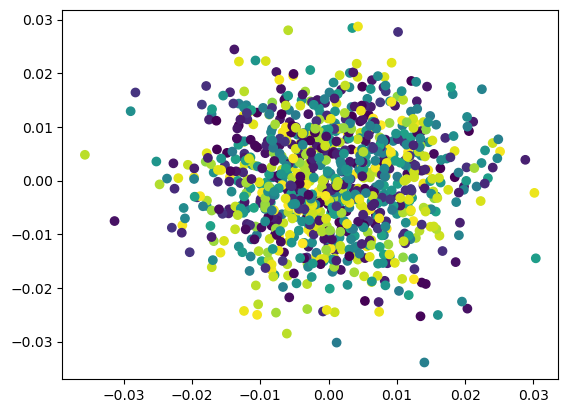

7589.0703


2.386: 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.01it/s]


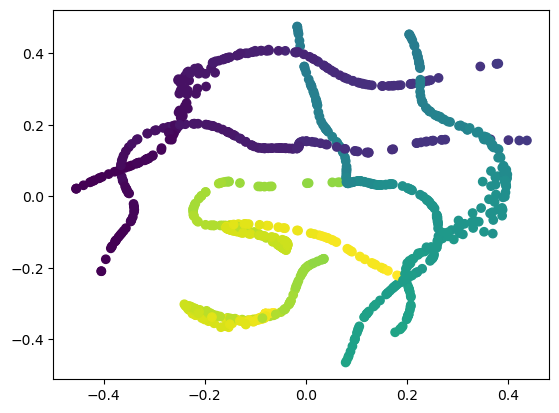

In [145]:
from tqdm import tqdm

#E  = np.random.uniform(size = (len(X),2)) * 1e-2
E = np.random.randn(len(X), 3) *  1e-2
plt.scatter(E[:,0] , E[:,1], c =  t_space[ X.argmax(axis =  1)])
plt.show()

print(loss(E,X))
steps = 10000
T   = np.geomspace(1e-9, 1e-9, steps) * 0
bar = tqdm(range(steps))
lr  = 1e-4
for i in bar:
    E =  E - lr * grad(E,X) + T[i] * np.random.normal(size = E.shape)
    bar.set_description("%.3f" % loss(E,X))

plt.scatter(E[:,0] , E[:,1], c =  t_space[ X.argmax(axis =  1)])
plt.show()

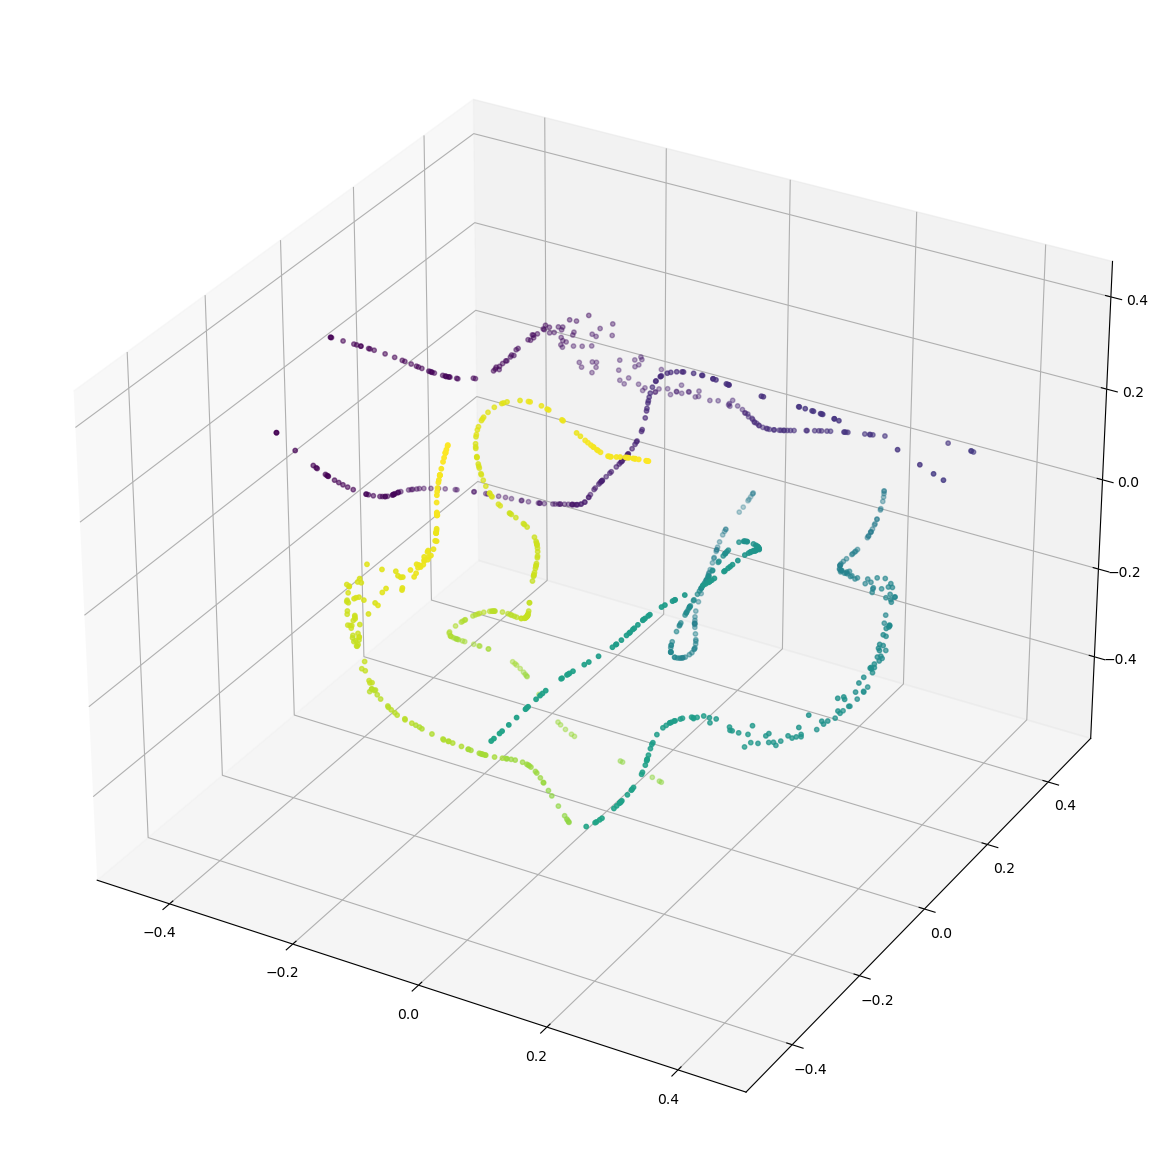

In [147]:
ax = plt.figure(figsize = (15,15)).add_subplot(projection = '3d')
ax.scatter(E[:,0] , E[:,1], E[:,2], c =  t_space[ X.argmax(axis =  1)], s = 10.)

# Test

(1000,)


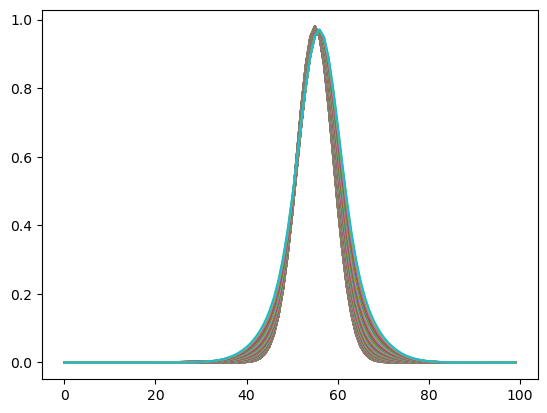

In [112]:
a = np.linspace(0,.4,100)
walk = batch_predict( a[:,None] * E[9] + (1 - a[:,None]) * E[100], E ,X) 
plt.plot(walk.T)
plt.show()

# Mnist

In [5]:
from  keras.datasets.mnist import load_data

In [62]:
(X_train,Y_train),(_,__) = load_data()
X_train = X_train[:500].reshape(-1,28*28).astype(float) / 255.
Y_train = Y_train[:len(X_train)]

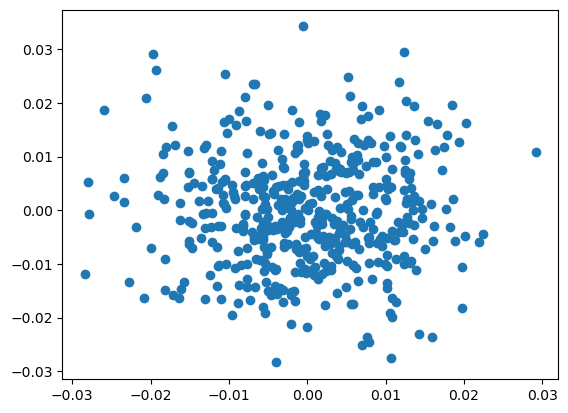

25605.705


10920.816 0.000100000000: 100%|█████████████████████████████████████████████████| 10000/10000 [01:38<00:00, 101.02it/s]


In [70]:
from tqdm import tqdm


E =  np.random.randn(len(X_train), 2) *  1e-2
plt.scatter(E[:,0] , E[:,1])
plt.show()

print(loss(E,X_train))
lr  = 1e-4

steps = 10000
T   = np.geomspace(1e-2, 1e-9, steps)
bar = tqdm(range(steps))
for i in bar:
    E =  E - lr * grad(E,X_train) + np.random.normal(size = E.shape) * T[i]
    #if loss(new_E,X_train) <= loss(E,X_train):
    #    lr *= 1.5
    #    E   = new_E
    #else:
    #    lr *= 0.8
    bar.set_description("%.3f %.12f" % (loss(E,X_train),lr))

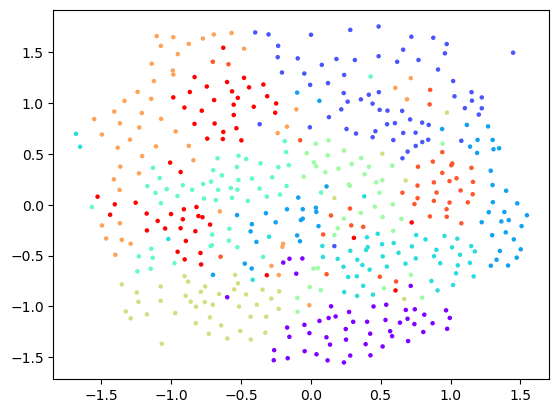

In [71]:
plt.scatter(E[:,0] , E[:,1], c = Y_train, cmap = 'rainbow', s = 5.)
plt.show()